# EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from scipy import fftpack

In [2]:
raw_data = "../raw/train.csv"
sub_data = "../raw/sample_submission.csv"
test_data = "../raw/test/{}.csv" 
proc_data = "../processed/{}"

In [3]:
df = pd.read_csv(sub_data, header=0).set_index("seg_id")
df["time_to_failure"] = 5
df.to_csv("qqq.csv")

In [11]:
0.146 + 0.134 + 0.146 + 0.134 + 0.131

0.6910000000000001

In [13]:
0.146 + 0.134 + 0.146 + 0.134 + 0.131 + 0.128 + 0.125

0.9440000000000001

In [54]:
df = pd.read_csv(raw_data, header=0, nrows=5656574)
df.columns = ["x", "y"]

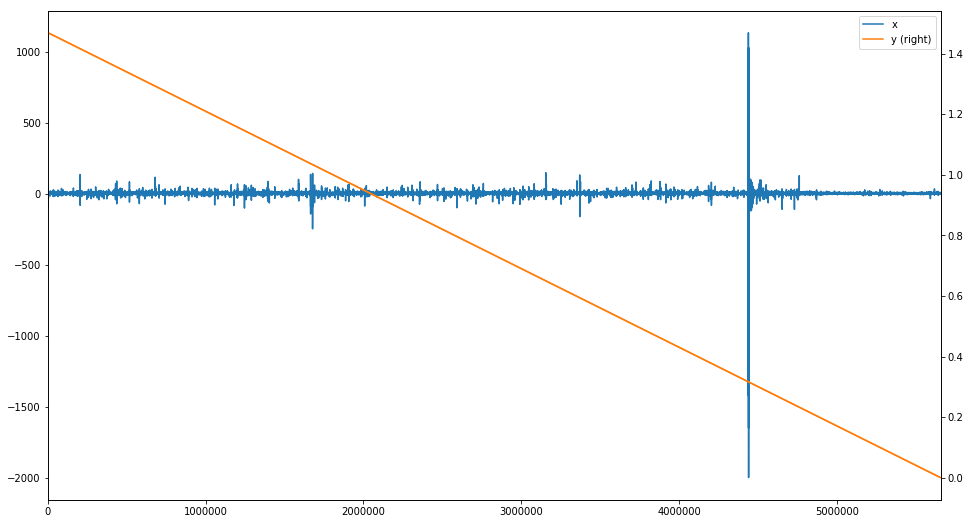

In [55]:
df.loc[::100,:].plot(figsize=(16,9), secondary_y=["y"])

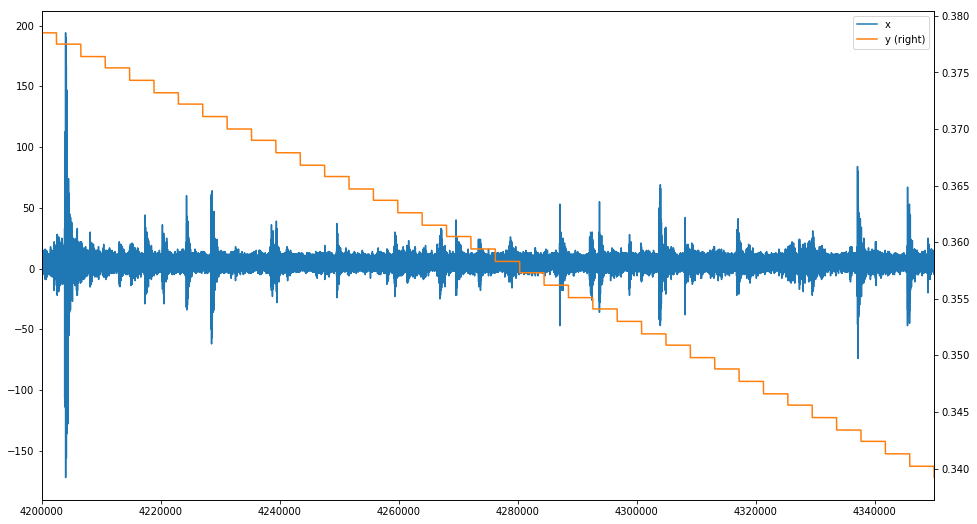

In [64]:
block = 150000
num = 28
df.loc[num * block: (num + 1) * block].plot(figsize=(16,9), secondary_y=["y"])

In [23]:
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import pacf, acf

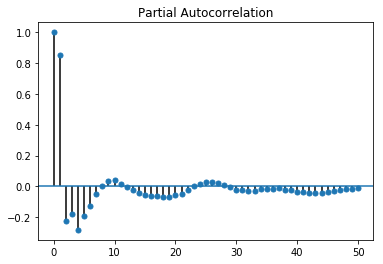

In [65]:
# _ = tsaplots.plot_acf(df.loc[num * block: (num + 1) * block].x)
_ = tsaplots.plot_pacf(df.loc[num * block: (num + 1) * block].x, lags=50)

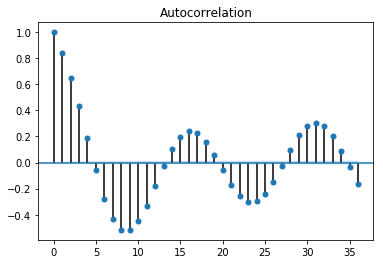

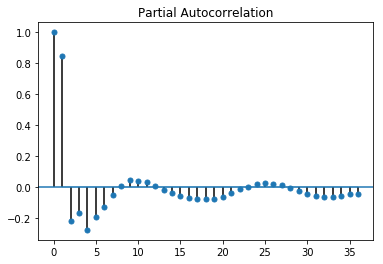

In [25]:
_ = tsaplots.plot_acf(df.loc[num * block: (num + 1) * block].x, lags=36)
_ = tsaplots.plot_pacf(df.loc[num * block: (num + 1) * block].x, lags=36)

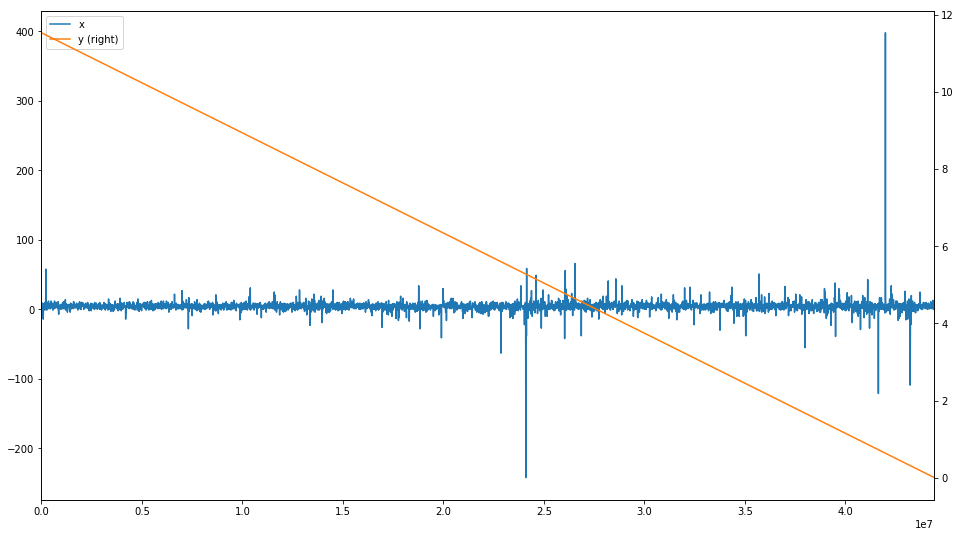

In [110]:
df = pd.read_csv(raw_data, skiprows=5656574, nrows=44429303)
df.columns = ["x", "y"]
df.loc[::10000,:].plot(figsize=(16,9), secondary_y=["y"])

In [38]:
summary = []
for name in tqdm_notebook(pd.read_csv(sub_data).seg_id):
    summary.append(pd.read_csv(test_data.format(name)).describe())

In [69]:
def yield_train_blocks(chunksize=150000):
    yield from pd.read_csv(
        raw_data, 
        names=["x", "y"], 
        dtype={"x": "int32", "y": "float32"}, 
        skiprows=1, 
        chunksize=chunksize
    )

In [70]:
def yield_sub_series():
    min_y = None
    blocks = []
    for block in yield_train_blocks():
        blocks.append(block)
        block_min_time = block.y.min()
        if min_y is None or block_min_time < min_y:
            min_y = block_min_time
            continue
        df = pd.concat(blocks, ignore_index=True)
        end_of_series = df.y.idxmin()
        blocks = [df.loc[end_of_series+1:]]
        min_y = blocks[0].y.min()
        yield df.loc[:end_of_series]
    yield pd.concat(blocks, ignore_index=True)

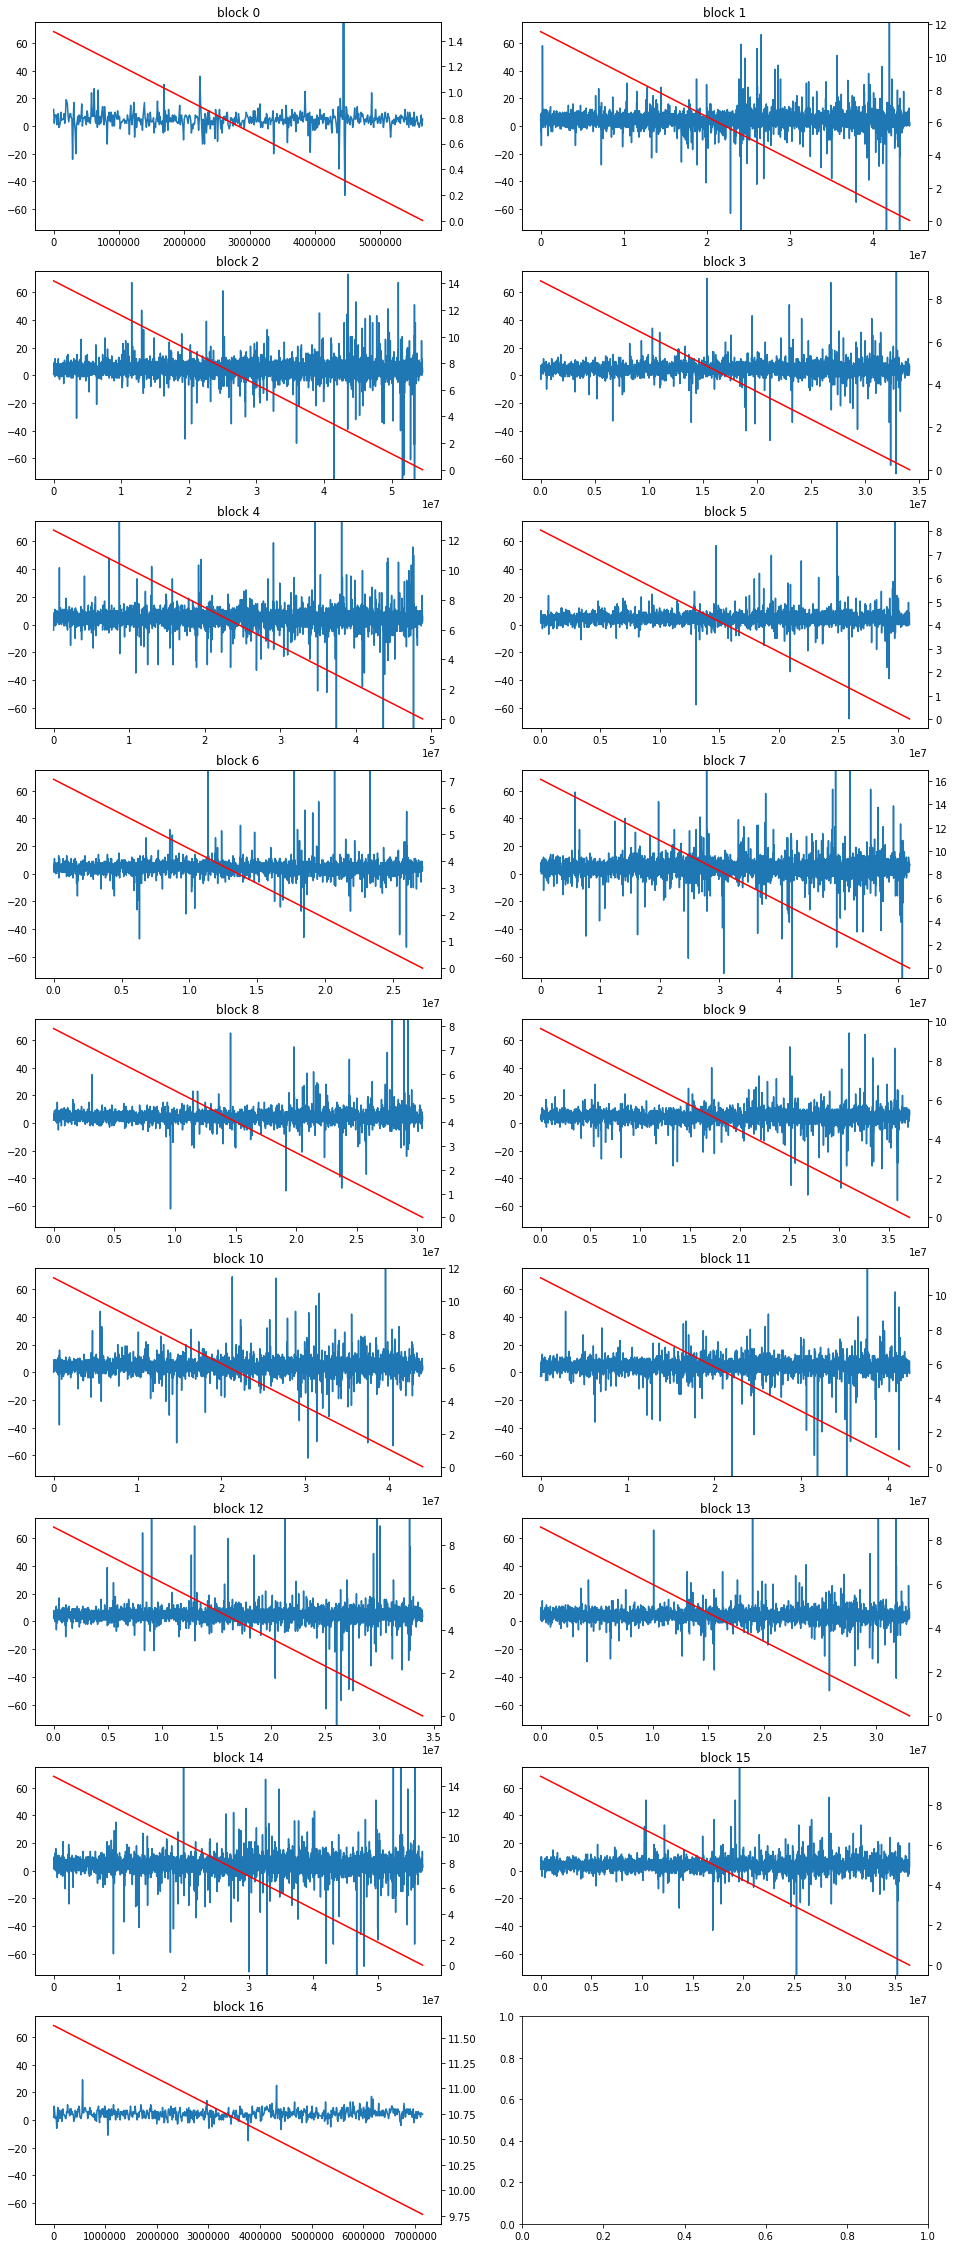

In [72]:
_, axs = plt.subplots(9, 2, figsize=(16, 9 * 9 / 2))
axs = axs.flatten()
for i, df in tqdm_notebook(enumerate(yield_sub_series())):
    axs[i].set_title(f"block {i}") 
    ax2 = axs[i].twinx()
    axs[i].set_ylim(-75, 75)
    step = len(df) // 5000
    axs[i].plot(df.x.loc[::step])   
    ax2.plot(df.y.loc[::step], color='r')   

# Анализ признаков

In [30]:
def yield_train_blocks(chunk_size=150000):
    dfs_gen = pd.read_csv(
        raw_data,
        names=["x", "y"],
        dtype={"x": "int32", "y": "float32"},
        skiprows=1,
        chunksize=chunk_size
    )
    for df in dfs_gen:
        time = df.y
        first_time = time.iloc[0]
        last_time = time.iloc[-1]
        if first_time < last_time:
            continue
        if len(df) == chunk_size:
            df.reset_index(drop=True, inplace=True)
            yield df.x, last_time

In [67]:
data = []
for df_x, y in tqdm_notebook(yield_train_blocks()):
    val = stattools.pacf(df_x.values, nlags=18)[1:]
    ind1 = np.argmin(val)
    val = val[ind1:]
    ind2 = np.argmax(val)
    data.append([ind1 + ind2, y])
    # data.append([np.argmin(stattools.pacf(df_x.values, nlags=12)), y])

In [31]:
from statsmodels.tsa import stattools

In [74]:
(pd.DataFrame(data)[0] > 15).sum()

12

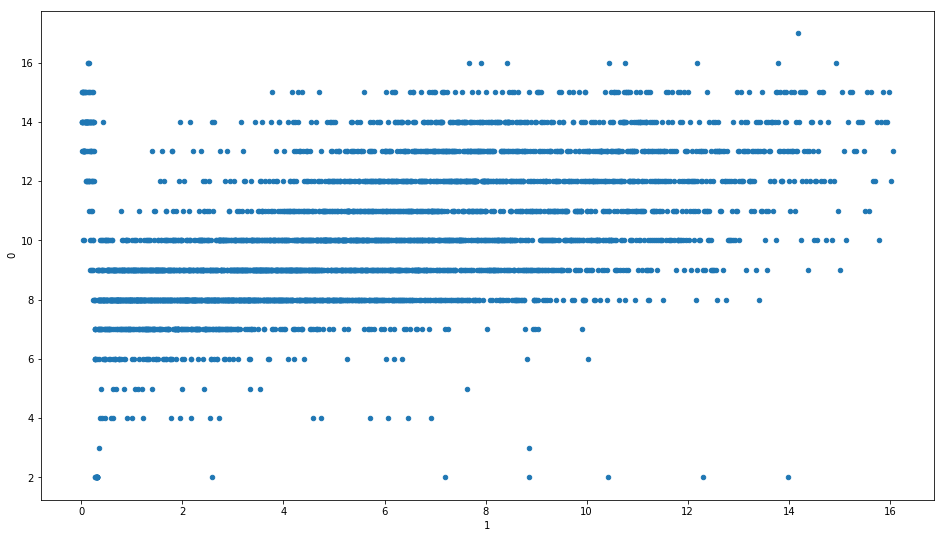

In [51]:
# где второй максимум
pd.DataFrame(data).plot.scatter(1, 0, figsize=(16,9))

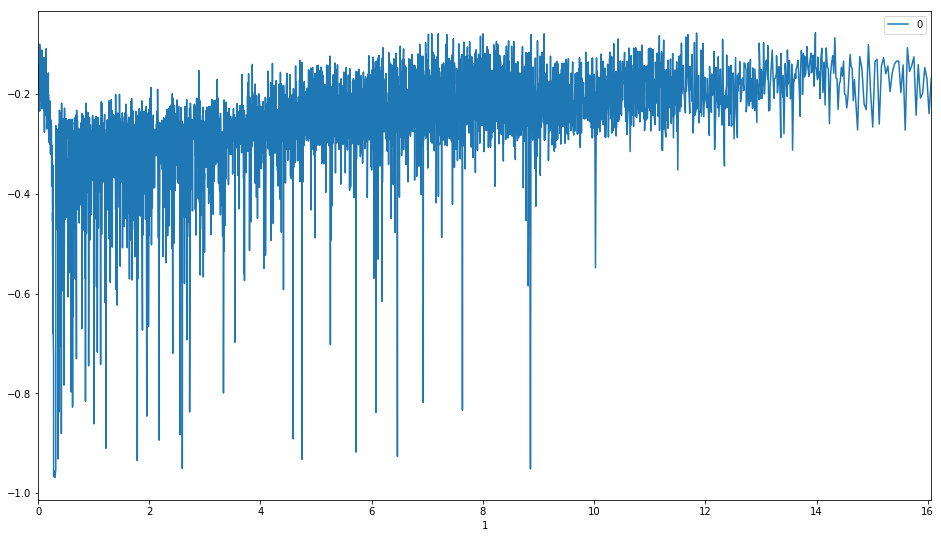

In [38]:
# какой минимум
pd.DataFrame(data).set_index(1).sort_index().plot(figsize=(16,9))

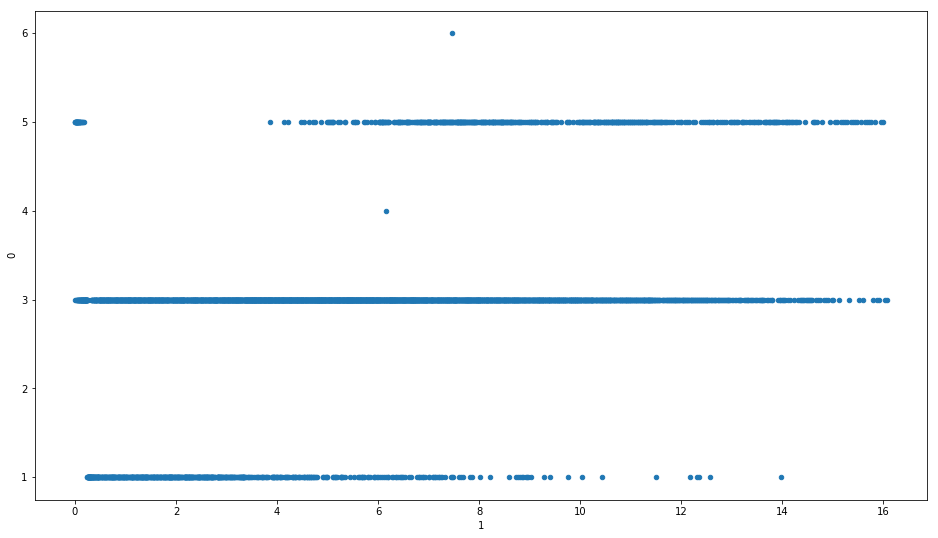

In [49]:
# где минимум
pd.DataFrame(data).plot.scatter(1, 0, figsize=(16,9))

# Анализ OOF предсказания

In [14]:
df = pd.read_pickle(proc_data.format("oof.pickle"))

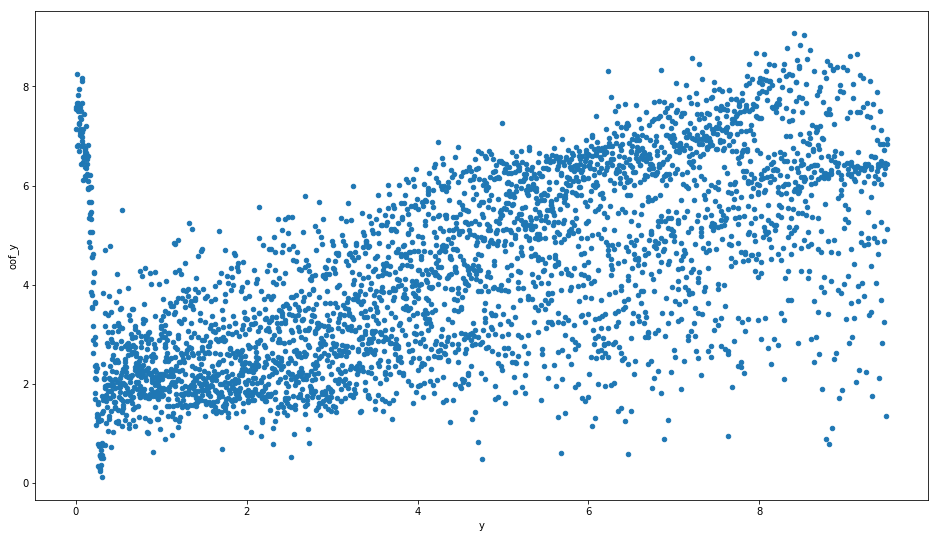

In [15]:
df.plot.scatter("y", "oof_y", figsize=(16,9))

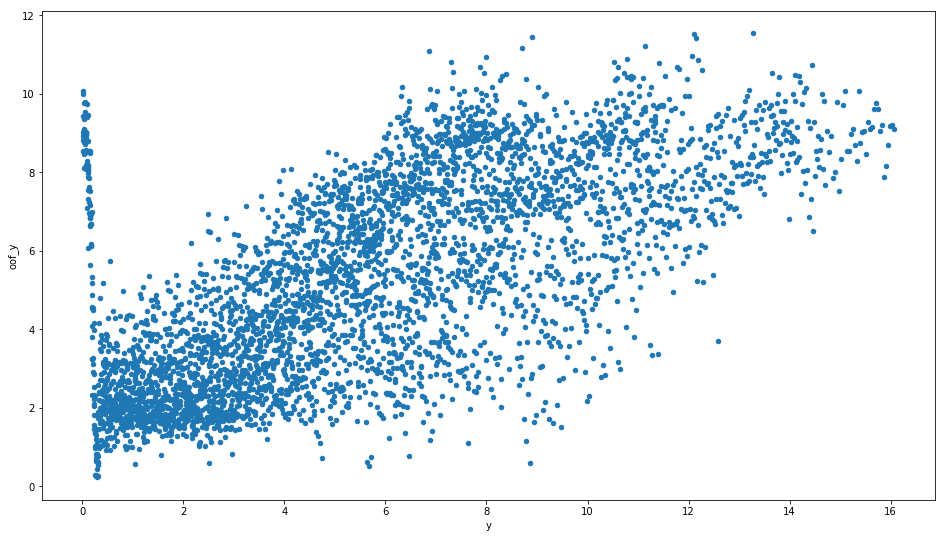

In [4]:
df.plot.scatter("y", "oof_y", figsize=(16,9))

In [22]:
df["oof_y"] = (df["oof_y"] - df["y"]).abs()
rez = df.groupby(lambda x: int(df.y.loc[x] * 20) / 20).agg({"oof_y": ["mean"]})

In [23]:
df.oof_y.min()

0.0006368007867805225

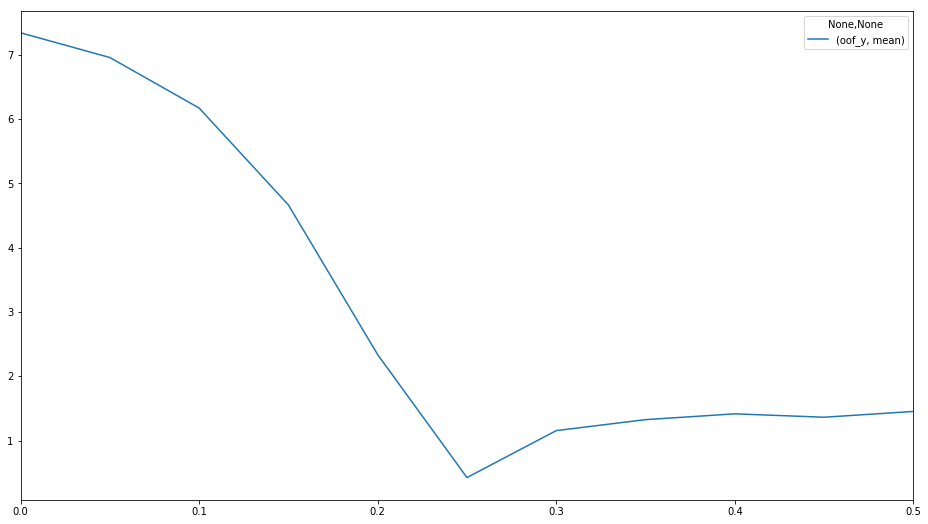

In [25]:
rez.plot(figsize=(16,9), xlim=(0, 0.5))

# Важность признаков

In [ ]:
pd.read_pickle(proc_data.format("importance.pickle"))